In [1]:
%pip install cma
from password import *

import matplotlib.pyplot as plt
import numpy as np


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Retrive CMAES runner object from file

In [2]:
CMAESfilePath = "data/CMA/cmaes_mixed_0.5.pkl" #some half circle. idk 
#CMAESfilePath = "cmaes_0.5.pkl"

#phaseName = "CMAES mixed" #transition between PID and CMA-ES
phaseName = "CMAES" #only muscular movement

### EXPERIMENT
from package.src.NRP_VC_addon.experiments.Mouse_Experiment.Mouse_Experiment_CMAES import Mouse_Experiment_CMAES

exp = Mouse_Experiment_CMAES(
    exp_id="nrpexperiment_robobrain_mouse_v4_0", #offline
    #exp_id="nrpexperiment_robobrain_mouse_v4_0_0", #online
    dataDirectory="data_old/",
    workingFolderDirectory="output/",
    templateFolder="data/Mouse_Experiment/templates/",
    muscleGTdir="data/",
    brainFileName=None,
    muscleValuesGTsource = "FFT",
    CMAES_mixed_input=None, #These will be overritten afterwards
    CMAES_input=None, #These have no effect as CMAES dureation is 0
    scenarioName="circle",
    frequency=0.5,
    folderInfix="_circle_1_",
    #Phases
    pid_init_duration=2,  # seconds
    pid_movement_duration=1,  # Periods
    CMAES_mixed_duration=0.5,  # Periods
    CMAES_duration=1,  # Periods
    saturation = 1/2 #every second timestep
)


### SIMULATOR
from package.src.NRP_VC_addon.NRP_Simulator import NRP_Simulator_Local, NRP_Simulator_Online, NRP_Simulator_Paralell

simulator = NRP_Simulator_Local()
#simulator = NRP_Simulator_Paralell(OCID_username=OCID_username, OCID_password=OCID_password )

#Set phase

phase = None
print("Phases:")
for p in exp.phases:
    print(f'\t{p}')
    if(p["name"] == phaseName):
        steps = p["duration"]/exp.stepSize
        phase = p

len_x = int(steps*exp.saturation)
        
print(f'Phase {phaseName} has originally {steps} steps (f={exp.frequency} Hz)\n\t-> with saturation factor of {exp.saturation}, {len_x} signals are created.')
        

#get X0
import pickle
import numpy as np

if(exp.muscleValuesGTsource == "plain"):
    v = 0.5
    x0 = [(v,v, v,v, v,v,v,v)]*len_x

elif(exp.muscleValuesGTsource == "FFT" or exp.muscleValuesGTsource == "CMA"):
    if( exp.scenarioName == "circle"):
        x0 = exp.getMuscleGT(phase, scenarioName=exp.scenarioName,
                             f=exp.frequency, X=1, Y=1, t_start=phase["t_start"], t_end=phase["t_start"]+phase["duration"])
    else:
        raise RuntimeError("Implement getMuscleGT parameters for other scenarios")
    
    if(len(x0) != len_x):
        print("Original x0 length: "+str(len(x0)))
        x0_trans = np.array(x0).transpose()
        x0_trans = [
            exp.interp_scipy( x0_column, np.linspace(phase["t_start"],phase["t_start"]+phase["duration"],len_x) )
            for x0_column in x0_trans]
        
        x0 = np.array(x0_trans).transpose()
        
        print("Interpolated (target) x0 length: "+str(len(x0)))

else:
    raise RuntimeError(f"Unknown muscle innervation gt source: \"{muscleValuesGTsource}\"")
    

### CMAES Runner
from package.src.NRP_VC_addon.CMAES_Runner import CMAES_Runner

cmaes = CMAES_Runner(
    templateExperiment = exp, #Experiment specific stuff
    templateSimulator = simulator, #Simulator specific stuff
    #CMAES specific stuff
    #CMAESfilePath="cmaes_mixed_0.5_v1_online.pkl",
    CMAESfilePath=CMAESfilePath,
    maxIteration = 100,
    phaseName = phaseName,
    len_x = 3,
    x0 = [(0.5,0.5, 0.5,0.5, 0.5,0.5,0.5,0.5)]*3
)
#loading a CMAES file will override the cmaes object. This includes 

INFO: [2022-12-14 15:54:37,601 - Configuration] Loading configuration file config.json
INFO: [2022-12-14 15:54:37,602 - VirtualCoach] Logging into the Storage Server as: nrpuser
INFO: [2022-12-14 15:54:37,608 - VirtualCoach] Ready.


Working in folder: output/Mouse_Experiment_CMAES_circle_1_2022-12-14_15:54:37/
longitudinal_f=0.5_periods=100.pkl
circle_f=0.25_periods=100.pkl
longitudinal_f=1_periods=100.pkl
circle_f=0.5_periods=100.pkl
circle_f=1_periods=100.pkl
circle_f=0.125_periods=100.pkl
transversal_f=0.25_periods=100.pkl
longitudinal_f=0.25_periods=100.pkl
transversal_f=1_periods=100.pkl
transversal_f=0.5_periods=100.pkl
longitudinal_f=0.125_periods=100.pkl
transversal_f=0.125_periods=100.pkl
Relevant GT file: data/FFT/circle_f=0.5_periods=100.pkl
Relevant GT file: data/FFT/circle_f=0.5_periods=100.pkl
Regenerate VC instance (age: 0.00s = 0.00min )
Phases:
	{'name': 'pid init', 't_start': 0, 'duration': 2}
	{'name': 'pid movement', 't_start': 2, 'duration': 2.0}
	{'name': 'CMAES mixed', 't_start': 4.0, 'duration': 1.0}
	{'name': 'CMAES', 't_start': 5.0, 'duration': 2.0}
Phase CMAES has originally 100.0 steps (f=0.5 Hz)
	-> with saturation factor of 0.5, 50 signals are created.
Relevant GT file: data/FFT/circl

## Visualizations - Preprocessing

In [4]:
#draw limits
limits = (-0.06,0.06)
self = cmaes

minimalRun = self.getMinimalRun()

#self.history.keys()

## Visualizations

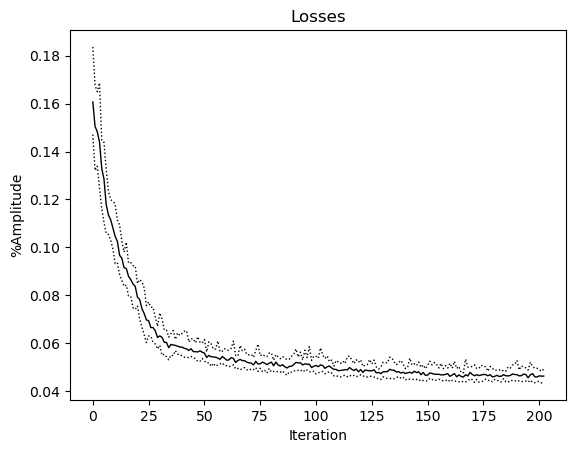

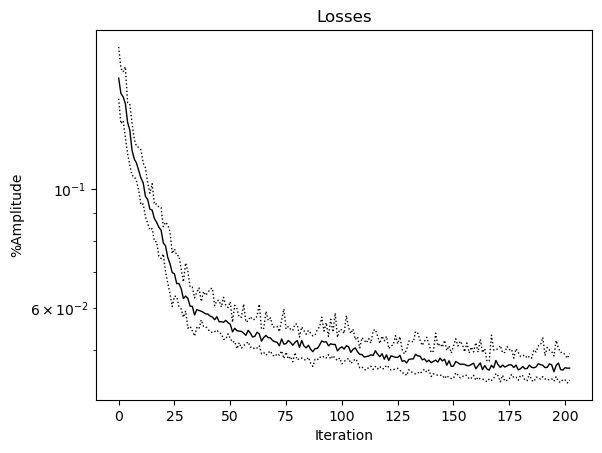

Best loss so far (it=201, run=4): 0.0021738079838946323


In [5]:
self.plotLosses(minimalRun, lw=1)
self.plotLosses(minimalRun, log=True, lw=1)
print(f'Best loss so far (it={minimalRun[0]}, run={minimalRun[1]}): {self.history["losses"][minimalRun[0]][minimalRun[1]]}')

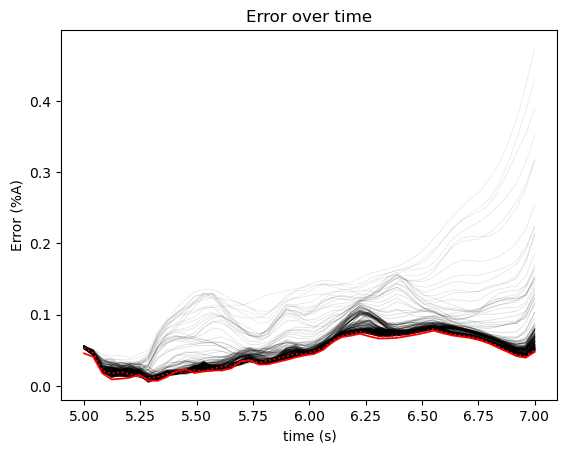

Smallest (mean) error so far (it=201, run=4): 0.043476159677892645


In [6]:
self.plotErrors(minimalRun, meanIteration=True, onlyLast=False)

best_error = np.mean( 
    ( self.history["losses"][minimalRun[0]][minimalRun[1]])/self.templateExperiment.scenario["A_max"]
)
print(f'Smallest (mean) error so far (it={minimalRun[0]}, run={minimalRun[1]}): {best_error}')


From 150 to 250


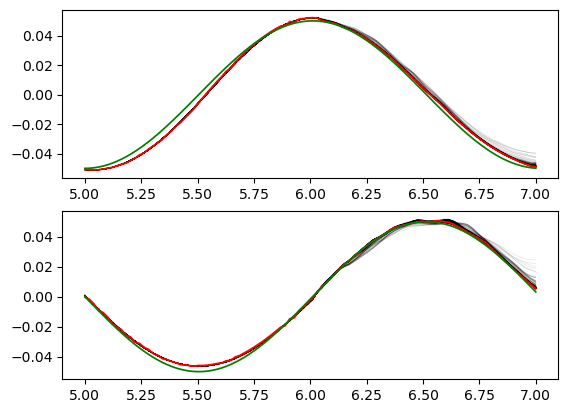

From 150 to 250


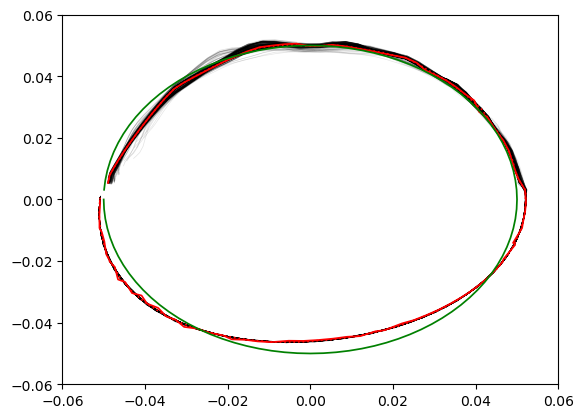

In [9]:
index_start = 150
index_end = 250

self.plotTrajectory(minimalRun, meanIteration=True, onlyLast=False, flatPlots=True, limits=limits,
                   index_start=index_start, index_end=index_end)
self.plotTrajectory(minimalRun, meanIteration=True, onlyLast=False, flatPlots=False, limits=limits,
                   index_start=index_start, index_end=index_end)


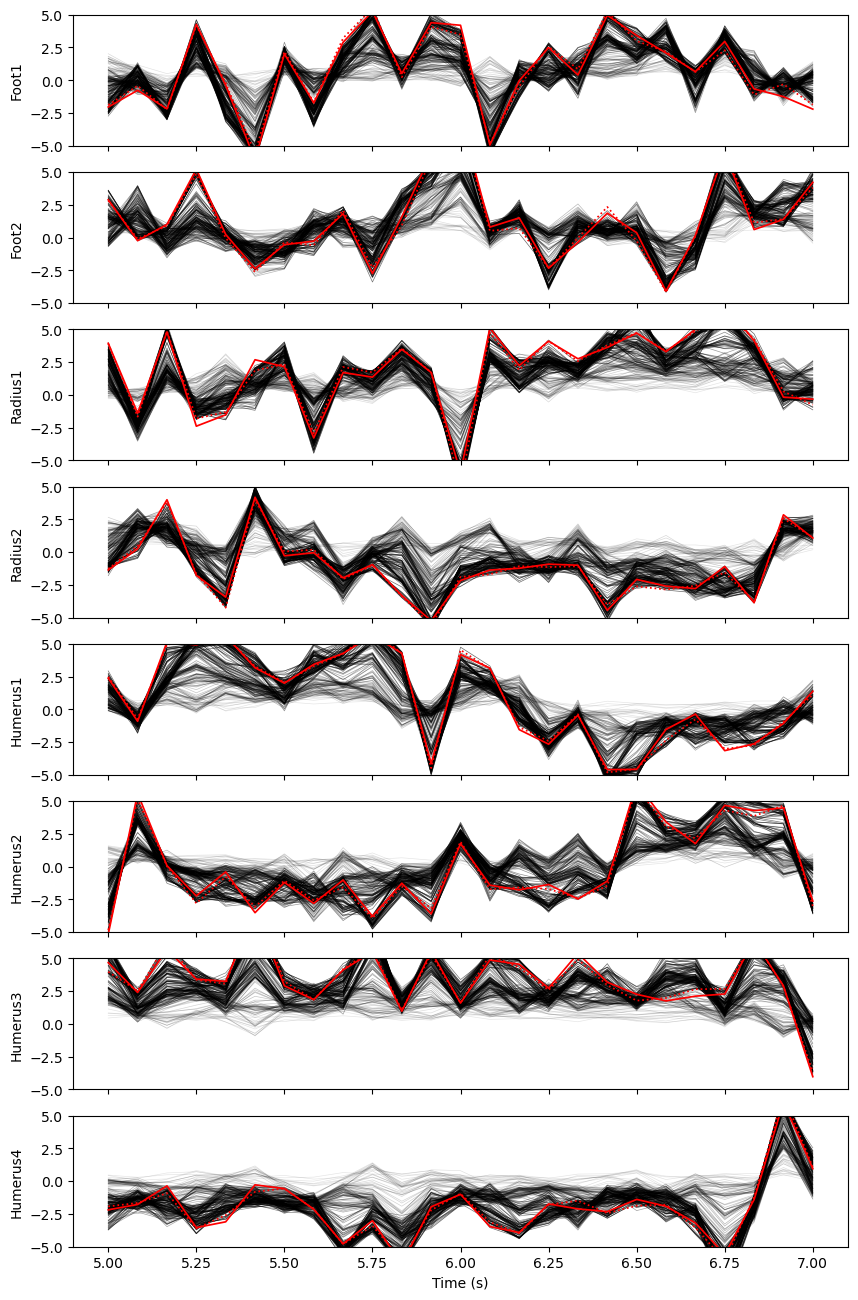

In [10]:
self.plotMuscleInput(minimalRun, scale = 5)


In [ ]:
#TODO: CMAES clippen (höhere performance)
#TODO: macht es einen unterscheid wenn man auf 0,1 clippt? ist das relevant?


In [ ]:
self.plotx0(self)
